# Clustering and Percentile Visualization of Positive Modic Labels 
CS3310 : Muftuler Lab Project 1 


This notebook explores the modic change radiomic data. Specifically this notebook explores the distribution of modic / non-modic vertebrae as there are only several samples in the data positive for modic changes. PCA and LDA dimensionality reduction are performed on the vertebrae radiomic features to explore how well these features can separate modic / non-modic change vertebrae. This notebook also includes beginning work to create a visualization organizing the vertebrae in the data based on their distance from a calculated centroid of the samples positive for modic changes. However, this visualization was scrapped as it was decided with Dr. Muftuler to stop exploring modic change data and focus only on disc degeneration. 

### Library Imports 

In [3]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Import VB Data Frame 

In [4]:
raw_radiomic_vb = pd.read_csv('../spine/data_radiomics_vertebrates.csv', index_col=0)

raw_radiomic_vb.sample(15)

original_firstorder_10Percentile  original_firstorder_90Percentile  \
S289_L2                             190.0                             381.0   
S251_L3                             165.0                             316.0   
S224_L1                             199.0                             360.0   
S240_L1                             217.0                             372.0   
S239_L5                             107.0                             190.0   
S221_L2                             114.0                             203.0   
S221_L5                             176.0                             343.0   
S214_L3                             143.0                             264.0   
S201_L5                             180.0                             390.0   
S283_L5                             124.0                             254.0   
S201_L3                             190.0                             405.0   
S253_L3                              64.0                             133.0   
S261_L3                             155.0                             317.0   
S236_L4                             182.0                             372.0   
S204_L1                             181.0                             409.0   

         original_firstorder_Energy  original_firstorder_Entropy  \
S289_L2                1.795394e+09                     3.724041   
S251_L3                1.787354e+09                     3.362300   
S224_L1                2.057540e+09                     3.451441   
S240_L1                1.853285e+09                     3.357927   
S239_L5                4.380165e+08                     2.491764   
S221_L2                4.758162e+08                     2.625425   
S221_L5                1.640099e+09                     3.544043   
S214_L3                1.492167e+09                     3.007263   
S201_L5                2.749534e+09                     3.784489   
S283_L5                8.100348e+08                     3.156132   
S201_L3                3.771068e+09                     3.829396   
S253_L3                2.571930e+08                     2.226162   
S261_L3                1.330143e+09                     3.495992   
S236_L4                2.224749e+09                     3.662931   
S204_L1                2.715070e+09                     3.894383   

         original_firstorder_InterquartileRange  original_firstorder_Kurtosis  \
S289_L2                                    95.0                      6.992836   
S251_L3                                    76.0                      8.010059   
S224_L1                                    83.0                      6.588053   
S240_L1                                    80.0                      3.402408   
S239_L5                                    43.0                      5.718615   
S221_L2                                    46.0                      8.201280   
S221_L5                                    78.0                     11.055353   
S214_L3                                    64.0                      4.272384   
S201_L5                                   102.0                      5.249868   
S283_L5                                    67.0                      6.700385   
S201_L3                                   111.0                      3.747303   
S253_L3                                    36.0                     10.834468   
S261_L3                                    80.0                      8.285645   
S236_L4                                    97.0                      4.776884   
S204_L1                                   120.0                      4.267130   

         original_firstorder_Maximum  original_firstorder_Mean  \
S289_L2                        856.0                281.983557   
S251_L3                        753.0                240.540448   
S224_L1                        772.0                283.779326   
S240_L1                        531.0                297.469908   
S239_L5                     

### Clean Up Data Frame 

In [5]:
radiomic_feature_names = list(raw_radiomic_vb.drop('Modic Changes', axis=1).columns)

# Drop first order features 
first_order_feat = list(np.array(radiomic_feature_names)[['firstorder' in feature for feature in radiomic_feature_names]])
radiomic_vb = raw_radiomic_vb.drop(first_order_feat, axis=1)

# Taking scoring from R1 as it is from radiologist 
radiomic_vb['Modic Changes'] = raw_radiomic_vb['Modic Changes'].apply(lambda x: 1 if int(x.split('/')[0]) > 0 else 0)
radiomic_vb['Modic Changes'] = radiomic_vb['Modic Changes'].astype('category')

vb_col = pd.Series(radiomic_vb.index).apply(lambda x: x.split('_')[1])
vb_col = vb_col.set_axis(radiomic_vb.index)
radiomic_vb['vb'] = vb_col

subj_col = pd.Series(radiomic_vb.index).apply(lambda x: x.split('_')[0])
subj_col = subj_col.set_axis(radiomic_vb.index)
radiomic_vb['subject'] = subj_col

radiomic_vb = radiomic_vb.drop(columns='Owestry score (ODI))')
radiomic_vb.sample(15)

original_glcm_Autocorrelation  original_glcm_ClusterProminence  \
S244_L4                     301.700104                     35205.147519   
S214_L5                      53.655726                       992.239461   
S204_L4                     182.505993                     21545.428357   
S297_L4                     217.855911                     24438.768951   
S293_L3                      65.515318                      1289.746154   
S285_L3                     104.635463                      2432.007291   
S244_L1                     524.222821                     60654.820919   
S287_L4                      88.828879                      3025.229384   
S202_L1                      60.464730                       569.098284   
S240_L4                     132.176013                      1617.999199   
S240_L2                     129.776325                      1443.856444   
S237_L5                     150.680328                      5713.703702   
S222_L4                     317.277540                     38211.204947   
S231_L3                     137.998990                      5414.454332   
S245_L1                     136.478061                      2343.497627   

         original_glcm_ClusterShade  original_glcm_ClusterTendency  \
S244_L4                  186.774278                     107.420380   
S214_L5                   32.728072                      14.307175   
S204_L4                  497.200714                      75.115099   
S297_L4                  451.209708                      50.321397   
S293_L3                   35.145609                      19.056785   
S285_L3                   21.788769                      22.121384   
S244_L1                  103.244477                     145.436483   
S287_L4                   76.295997                      25.808118   
S202_L1                    6.021163                      12.752681   
S240_L4                   14.254430                      18.376609   
S240_L2                   -5.410681                      18.875896   
S237_L5                  102.558653                      34.492875   
S222_L4                  578.163185                     109.529995   
S231_L3                  110.835922                      37.415309   
S245_L1                   50.875058                      25.181154   

         original_glcm_Contrast  original_glcm_Correlation  \
S244_L4               13.926407                   0.765986   
S214_L5                2.737521                   0.662671   
S204_L4                8.675155                   0.792289   
S297_L4               11.680508                   0.600250   
S293_L3                2.843121                   0.739162   
S285_L3                3.952133                   0.692502   
S244_L1               19.677783                   0.759345   
S287_L4                4.024367                   0.728517   
S202_L1                2.291886                   0.692680   
S240_L4                4.675066                   0.587634   
S240_L2                4.207483                   0.629014   
S237_L5                8.755339                   0.590330   
S222_L4               10.803197                   0.819887   
S231_L3                4.828527                   0.770823   
S245_L1                5.908922                   0.614783   

         original_glcm_DifferenceAverage  original_glcm_DifferenceEntropy  \
S244_L4                         2.633702                         2.899412   
S214_L5                         1.185226                         1.965250   
S204_L4                         2.121325                         2.648076   
S297_L4                         2.237202                         2.723255   
S293_L3                         1.192396                         1.957902   
S285_L3                         1.406164                         2.171496   
S244_L1                         3.157840                         3.136936   
S287_L4                         1.363995                         2.155559   
S

### Plot Modic Change Distribution

0    239
1      6
Name: Modic Changes, dtype: int64


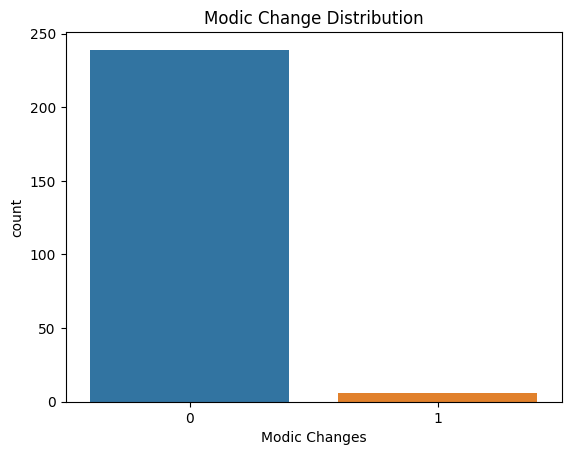

In [6]:
sns.countplot(x=radiomic_vb['Modic Changes'])
plt.title('Modic Change Distribution')
print(radiomic_vb['Modic Changes'].value_counts())

### Scaling Data

In [7]:
scaler = StandardScaler()
scaled_radiomics = scaler.fit_transform(radiomic_vb.drop(columns=['Modic Changes', 'vb', 'subject']))
print(scaled_radiomics.shape)

(245, 89)


### PCA or sumn

In [8]:
pca = PCA(n_components=3)
pca_reduced_radiomics = pca.fit_transform(scaled_radiomics)
print(pca_reduced_radiomics.shape)

(245, 3)


### Explained Variance by PC

In [9]:
print(pca.explained_variance_ratio_)

[0.58114088 0.13227382 0.06524693]


### Calculate Centroid

In [10]:
modic_labels = radiomic_vb['Modic Changes'].to_numpy().astype('bool')
modic_samples = pca_reduced_radiomics[modic_labels, :]
modic_centroid = modic_samples.mean(axis=0)
print(modic_centroid[:2])

[ 4.7016705  -1.18964866]


### Plot Data with Centroid 

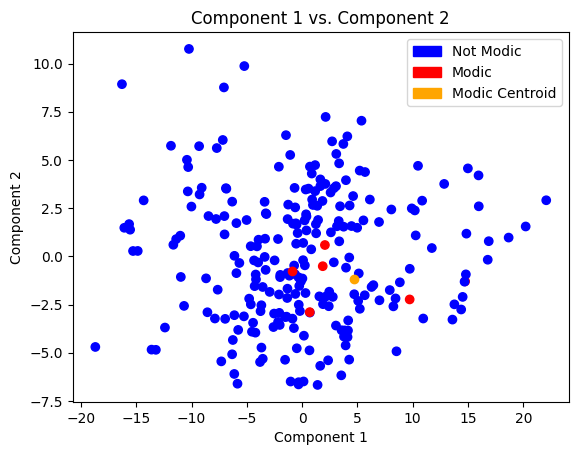

In [11]:
colors = {'blue':'Not Modic', 'red':'Modic'}

plt.scatter(pca_reduced_radiomics[:, 0], pca_reduced_radiomics[:, 1], c=radiomic_vb['Modic Changes'], cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(modic_centroid[0], modic_centroid[1], c='orange', label='Modic Centroid')
plt.title('Component 1 vs. Component 2')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
patches = [matplotlib.patches.Patch(color=color, label=change) for color, change in colors.items()]
patches.append(matplotlib.patches.Patch(color='orange', label='Modic Centroid'))
plt.legend(handles=patches)

### Calculate Distances from Centroid for Each Data Point

In [12]:
distances = np.linalg.norm(modic_centroid[:2] - pca_reduced_radiomics[:, :2], axis=1)
pca_df = pd.DataFrame(pca_reduced_radiomics[:, :2], columns=['comp_1', 'comp_2'])
pca_df['centroid_distance'] = distances
pca_df = pca_df.set_index(radiomic_vb.index)
pca_df['modic_changes'] = radiomic_vb['Modic Changes']
pca_df['subject'] = radiomic_vb['subject']
pca_df['vb'] = radiomic_vb['vb']
pca_df.head(15)

comp_1    comp_2  centroid_distance modic_changes subject  vb
S257_L1 -7.785841  1.936296          12.872819             0    S257  L1
S257_L2 -7.016971  1.139516          11.947868             0    S257  L2
S257_L3 -5.678678 -0.343998          10.414737             0    S257  L3
S257_L4 -2.937577 -1.845102           7.667315             0    S257  L4
S257_L5 -4.085689  0.518227           8.951789             0    S257  L5
S259_L1 -1.161239 -1.005313           5.865807             0    S259  L1
S259_L2  0.303125 -1.903610           4.456113             0    S259  L2
S259_L3 -0.305674 -2.511032           5.178760             0    S259  L3
S259_L4 -2.095165 -1.979114           6.842531             0    S259  L4
S259_L5 -3.979310 -0.316212           8.724810             0    S259  L5
S261_L1  2.124389  7.232644           8.807803             0    S261  L1
S261_L2  1.173444  4.732941           6.893870             0    S261  L2
S261_L3  0.870117  4.294911           6.690381             0    S261  L3
S261_L4  0.578371  3.513099           6.254393             0    S261  L4
S261_L5 -2.106275  4.648927           8.968672             0    S261  L5

### Sort Data by Distance to Centroid 

In [13]:
pca_df = pca_df.sort_values('centroid_distance')

percentiles = np.percentile(pca_df['centroid_distance'], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
percentiles[0] -= 0.0001
pca_df['bin'] = pd.cut(pca_df['centroid_distance'], bins=percentiles)
bin_dict = {k:v for k, v in zip(pca_df['bin'].unique(), range(10))}
pca_df['bin'] = pca_df['bin'].map(lambda x: bin_dict[x])
pca_df.head(20)

comp_1    comp_2  centroid_distance modic_changes subject  vb bin
S204_L1  5.122938 -0.887192           0.518601             0    S204  L1   0
S265_L4  4.712016 -1.966559           0.776979             0    S265  L4   0
S227_L2  3.967397 -0.587662           0.949498             0    S227  L2   0
S201_L5  5.070271 -2.312199           1.181518             0    S201  L5   0
S285_L5  4.261322 -0.061263           1.211264             0    S285  L5   0
S227_L3  5.660530 -2.018705           1.267575             0    S227  L3   0
S273_L2  5.217615 -2.721917           1.616801             0    S273  L2   0
S263_L5  6.280490 -1.588873           1.628512             0    S263  L5   0
S227_L5  6.441826 -1.493912           1.766556             0    S227  L5   0
S236_L3  2.865105 -0.310121           2.036306             0    S236  L3   0
S265_L3  2.771989 -2.104029           2.135360             0    S265  L3   0
S273_L5  4.163723 -3.324541           2.201625             0    S273  L5   0
S285_L4  2.449338 -1.835115           2.342996             0    S285  L4   0
S240_L3  3.357037  0.779143           2.384152             0    S240  L3   0
S227_L4  6.993024 -2.279776           2.537455             0    S227  L4   0
S263_L2  2.408707 -2.587965           2.685697             0    S263  L2   0
S226_L5  4.977295  1.483373           2.687194             0    S226  L5   0
S263_L4  4.145911 -3.847236           2.715076             0    S263  L4   0
S236_L4  2.130254 -2.088435           2.723968             0    S236  L4   0
S265_L5  4.463483  1.571340           2.771243             0    S265  L5   0

### Plot and Show Percentile of Distance 

Text(0.5, 1.0, 'Modic Change Data Percentile Distance from Centroid')

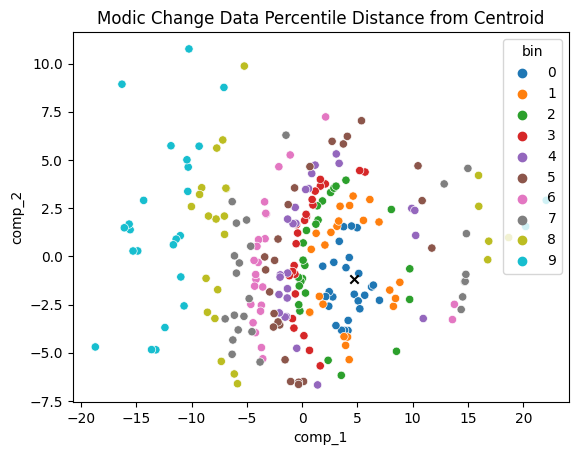

In [14]:
sns.scatterplot(data=pca_df, x='comp_1', y='comp_2', hue='bin')
plt.scatter(modic_centroid[0], modic_centroid[1], c='black', marker='x')
plt.title('Modic Change Data Percentile Distance from Centroid')

### Print Centroid Coords

In [15]:
print(modic_centroid[:2])

[ 4.7016705  -1.18964866]


### Find Points with Modic Changes 

In [16]:
pca_df[pca_df['modic_changes'] == 1]

comp_1    comp_2  centroid_distance modic_changes subject  vb bin
S251_L4   1.862888 -0.511957           2.918553             1    S251  L4   0
S251_L5   2.059486  0.587269           3.184113             1    S251  L5   1
S214_L1   0.687443 -2.896356           4.361980             1    S214  L1   1
S204_L4   9.725160 -2.235784           5.131262             1    S204  L4   2
S224_L5  -0.867093 -0.783145           5.583581             1    S224  L5   3
S204_L5  14.742139 -1.297919          10.041053             1    S204  L5   7

### LDA

In [18]:
lda = LinearDiscriminantAnalysis() # ValueError: n_components cant be larger than min(n_features, n_classes - 1).
lda_reduced_radiomics = lda.fit_transform(scaled_radiomics, radiomic_vb['Modic Changes'])
print(lda.explained_variance_ratio_)

[1.]


### Plot LDA Data 

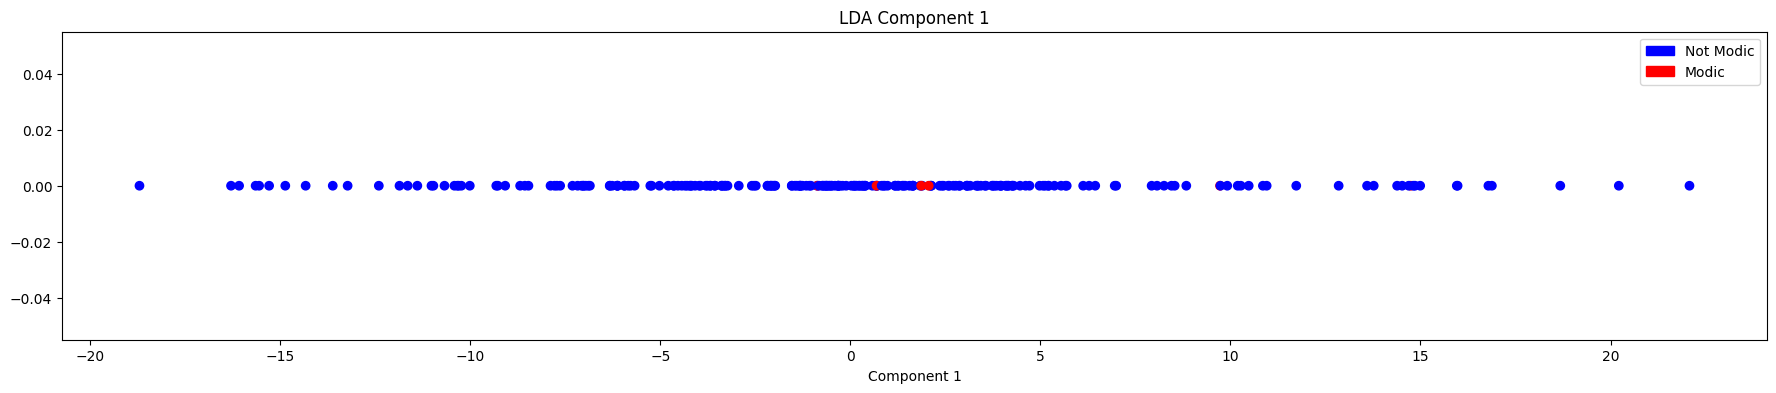

In [19]:
colors = {'blue':'Not Modic', 'red':'Modic'}

plt.figure(figsize=(22, 4))
plt.scatter(pca_reduced_radiomics[:, 0], [0]*len(pca_reduced_radiomics[:, 0]), c=radiomic_vb['Modic Changes'], cmap=matplotlib.colors.ListedColormap(colors))
plt.title('LDA Component 1')
plt.xlabel('Component 1')
plt.ylabel('')
patches = [matplotlib.patches.Patch(color=color, label=change) for color, change in colors.items()]
plt.legend(handles=patches)

## Results :

- The features extracted by pyradiomics are currently not able to reliably separate Modic samples from Non-Modic vertebrae when LDA is applied to project the data onto one component. The data here is projected onto 1 component because the labels have been reduced to two classes, Modic and Not Modic, and LDAs maximum number of components is min(n_features, n_classes - 1) thus only one component can be extracted from the data. Some insight as to why this could be is as follows. Modic changes can be present in up to a third of the vertebra's area or as little as just a corner of the vertebra, currently radiomic features are extracted over the entire vertebra mask. Since many of the few modic-positive samples in the data consist of modic changes covering a small area of the vertebra, it is very possible that the features and textures from the large portion of healthy vertebra overpowers the features and textures of the small area of the vertebra with the modic change.
- There is a severe imbalance of healthy and degenerated vertebrae in the dataset. After combining the modic labels from each of the three raters (Rater 1 was taken as the most truthy label as they were a trained radiologist, while the other two raters were Dr. Muftuler and a colleague) only 6 vertebrae in the data contain modic changes, while the remaining 239 vertebrae are healthy. Further, these 6 samples only exhibit modic changes type 1 (n=1) and type 2 (n=5), meaning that within the data there are no samples exhibiting type 3 modic changes. Statistical testing was attempted on this data with little success, all P-Values returned by both Kruskal-Wallis and ANOVA were above the threshold for rejection [See `vertebraeT1_EDA.ipynb`]. 
- From here out, no further work with modic changes will be done and the project will focus on training models to predict Pfirrmann Degeneration of discs.